In [2]:
import os
import glob
import numpy as np
from PIL import Image

IMG_W, IMG_H = 128, 32   # (width, height)

def load_images_and_labels(folder):
    images = []
    labels = []

    # Lấy tất cả file .png, sắp xếp cho cố định thứ tự
    for img_path in sorted(glob.glob(os.path.join(folder, "*.png"))):
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        txt_path = os.path.join(folder, base_name + ".txt")

        if not os.path.exists(txt_path):
            print(f"Không tìm thấy nhãn cho: {img_path}")
            continue

        # Đọc nhãn
        with open(txt_path, "r", encoding="utf-8") as f:
            label = f.read().strip()

        # Đọc ảnh, chuyển grayscale
        img = Image.open(img_path).convert("L")
        w, h = img.size

        # Tính tỉ lệ scale để vừa với 128x32 mà không méo hình
        scale = min(IMG_W / w, IMG_H / h)
        new_w = int(w * scale)
        new_h = int(h * scale)

        # Resize theo tỉ lệ
        img_resized = img.resize((new_w, new_h), Image.BILINEAR)

        # Tạo canvas trắng 128x32, rồi dán ảnh đã resize vào (căn giữa)
        # Nếu nền đen, đổi color=0
        canvas = Image.new("L", (IMG_W, IMG_H), color=255)
        offset_x = (IMG_W - new_w) // 2
        offset_y = (IMG_H - new_h) // 2
        canvas.paste(img_resized, (offset_x, offset_y))

        # Chuyển sang numpy
        arr = np.array(canvas, dtype=np.uint8)  # shape: (32, 128)
        images.append(arr)
        labels.append(label)

    # (N, 32, 128)
    X = np.stack(images, axis=0)

    # Mảng nhãn dạng string
    y = np.array(labels, dtype=object)

    return X, y


folder = r"C:\Users\ADMIN\Downloads\VNOnDB_processed\Data_processed\InkData_word_processed" 
X, y = load_images_and_labels(folder)

print("X shape:", X.shape)      # (N, 32, 128)
print("Số lượng mẫu:", len(y))
print("Ví dụ nhãn:", y[0])

    # Nếu dùng cho Keras/PyTorch:
    # X = X.astype("float32") / 255.0
    # X = X[..., np.newaxis]  # -> (N, 32, 128, 1)

X shape: (110746, 32, 128)
Số lượng mẫu: 110746
Ví dụ nhãn: Bản


In [3]:
save_path = "word_128x32.npz"

np.savez_compressed(save_path, X=X, y=y)
print("Đã lưu vào:", save_path)

Đã lưu vào: word_128x32.npz


Shape ban đầu của X: (110745, 32, 128)
Số lượng nhãn ban đầu: 110745
Tổng số mẫu ban đầu: 110745
Tổng số mẫu sau khi làm sạch: 110745 (đã xoá 0 mẫu lỗi/nhiễu)
Pixel min (trước chuẩn hoá): 149
Pixel max (trước chuẩn hoá): 255
Tổng số ảnh: 110745
Tổng số nhãn khác nhau: 3511
Shape của mỗi ảnh: (32, 128)
Các shape khác nhau: {(32, 128)}
Giá trị pixel trung bình (mean) sau chuẩn hoá: 0.9941650417245734
Giá trị pixel nhỏ nhất (min) sau chuẩn hoá: 0.0
Giá trị pixel lớn nhất (max) sau chuẩn hoá: 1.0


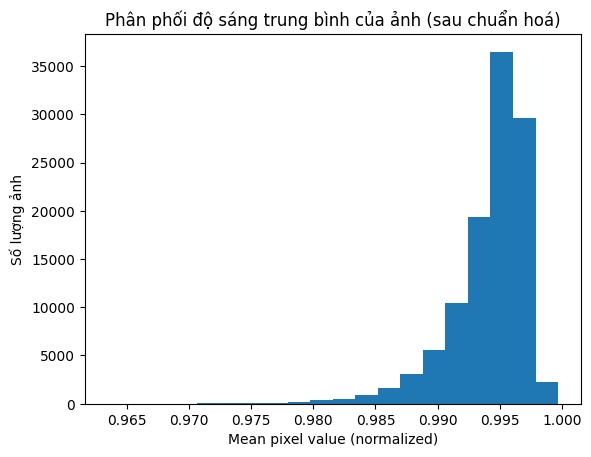

Số ảnh quá tối (mean < 0.1): 0
Số ảnh quá sáng (mean > 0.9): 110745
Top 10 nhãn phổ biến: [('có', 1213), ('là', 1126), ('và', 1112), ('người', 1025), ('của', 973), ('không', 900), ('một', 897), ('được', 875), ('công', 805), ('đã', 796)]


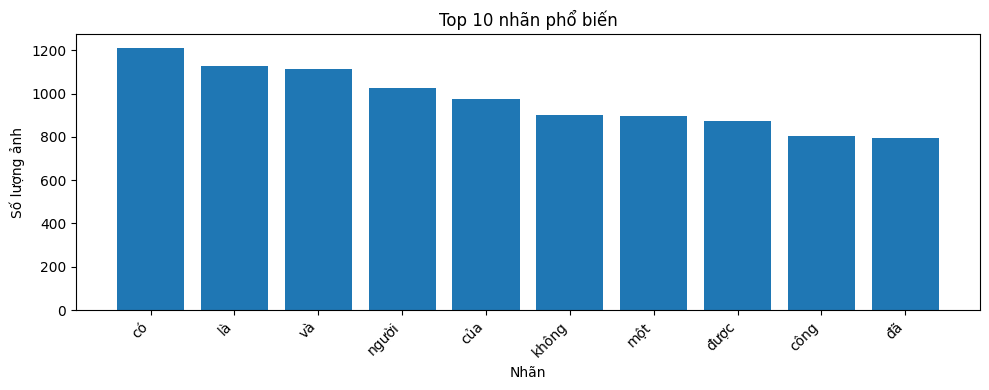

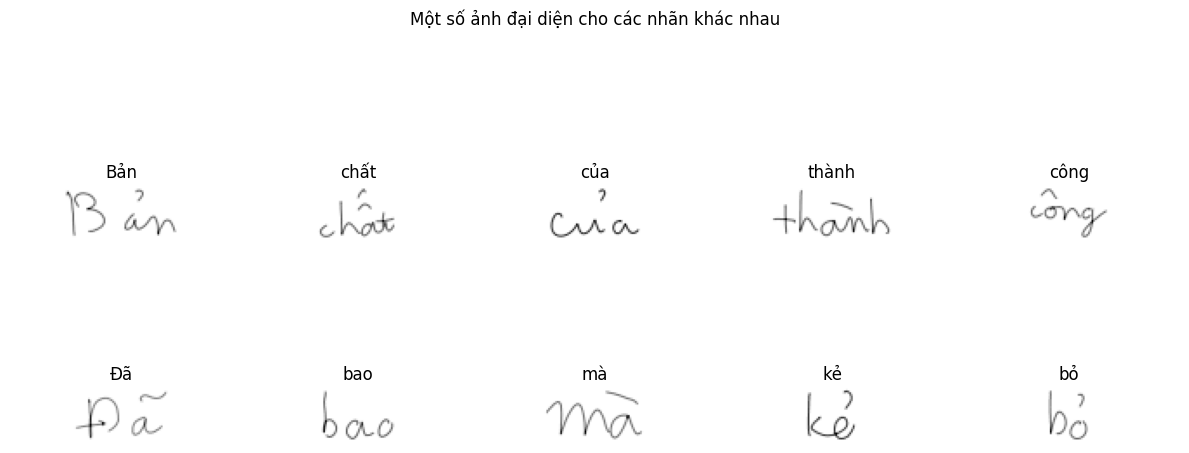

In [5]:

import matplotlib.pyplot as plt
from collections import Counter
# ===== 1. Chuẩn bị & làm sạch dữ liệu =====
X = np.array(X)                # (N, H, W)
y = np.array(y, dtype=object)  # danh sách nhãn

print("Shape ban đầu của X:", X.shape)
print("Số lượng nhãn ban đầu:", len(y))

assert len(X) == len(y), "Số ảnh và số nhãn không khớp!"

def is_bad_sample(img, label, eps=1e-6):
    """Trả về True nếu mẫu bị lỗi / nhiễu."""
    # Thiếu ảnh hoặc nhãn
    if img is None or label is None:
        return True

    # Nhãn rỗng
    if isinstance(label, str) and label.strip() == "":
        return True

    # Ảnh có NaN hoặc Inf
    if not np.isfinite(img).all():
        return True

    # Ảnh toàn một màu (trắng/đen/xám) -> xem như nhiễu
    if img.max() - img.min() < eps:
        return True

    return False

valid_indices = [i for i in range(len(X)) if not is_bad_sample(X[i], y[i])]
X = X[valid_indices]
y = y[valid_indices]

print(f"Tổng số mẫu ban đầu: {len(valid_indices) + (len(X) - len(valid_indices))}")
print(f"Tổng số mẫu sau khi làm sạch: {len(X)} (đã xoá {len(valid_indices) - len(X)} mẫu lỗi/nhiễu)")

# ===== 2. Chuẩn hoá pixel về [0,1] =====
global_min = X.min()
global_max = X.max()
print("Pixel min (trước chuẩn hoá):", global_min)
print("Pixel max (trước chuẩn hoá):", global_max)

images = (X - global_min) / (global_max - global_min)  # (N, H, W)

# ===== 3. Thống kê cơ bản =====
print("Tổng số ảnh:", len(images))
print("Tổng số nhãn khác nhau:", len(set(y)))

print("Shape của mỗi ảnh:", images[0].shape)
unique_shapes = set(img.shape for img in images)
print("Các shape khác nhau:", unique_shapes)

means = images.mean(axis=(1, 2))
mins = images.min(axis=(1, 2))
maxs = images.max(axis=(1, 2))

print("Giá trị pixel trung bình (mean) sau chuẩn hoá:", means.mean())
print("Giá trị pixel nhỏ nhất (min) sau chuẩn hoá:", mins.min())
print("Giá trị pixel lớn nhất (max) sau chuẩn hoá:", maxs.max())

plt.figure()
plt.hist(means, bins=20)
plt.title("Phân phối độ sáng trung bình của ảnh (sau chuẩn hoá)")
plt.xlabel("Mean pixel value (normalized)")
plt.ylabel("Số lượng ảnh")
plt.show()

too_dark = np.where(means < 0.1)[0]
too_bright = np.where(means > 0.9)[0]
print("Số ảnh quá tối (mean < 0.1):", len(too_dark))
print("Số ảnh quá sáng (mean > 0.9):", len(too_bright))

# ===== 4. Phân phối nhãn =====
label_counts = Counter(y)
print("Top 10 nhãn phổ biến:", label_counts.most_common(10))

plt.figure(figsize=(10, 4))
top_labels = label_counts.most_common(10)
plt.bar([l for l, _ in top_labels], [c for _, c in top_labels])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 nhãn phổ biến")
plt.xlabel("Nhãn")
plt.ylabel("Số lượng ảnh")
plt.tight_layout()
plt.show()



# ===== 5. Hiển thị một vài ảnh đại diện cho các nhãn khác nhau =====
shown = set()
plt.figure(figsize=(12, 6))
count = 1
for img, label in zip(images, y):
    if label not in shown:
        plt.subplot(2, 5, count)
        plt.title(str(label))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        shown.add(label)
        count += 1
        if count > 10:
            break

plt.suptitle("Một số ảnh đại diện cho các nhãn khác nhau")
plt.tight_layout()
plt.show()